In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cisc6000-deep-learning-hw1/sample_submission.csv
/kaggle/input/cisc6000-deep-learning-hw1/mnist.train.npy
/kaggle/input/cisc6000-deep-learning-hw1/mnist.trainlabel.npy
/kaggle/input/cisc6000-deep-learning-hw1/mnist.test.npy


## 2. Build Your Own Neural Network

In [3]:
# Student ID: A19737173
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random
import math
from sklearn.model_selection import train_test_split

def seed_everything(SEED): 
    np.random.seed(SEED) 
    random.seed(SEED)

seed_everything(7173)

class Layer:
    
    def __init__(self, input_size, out_size, activation_func):
        
        '''
        init Weight and Bias 
        
        '''
        self.activation_func = activation_func
        self.W = np.random.randn(out_size, input_size)
        self.b = np.random.randn(self.W.shape[0],1)

    def activation_function(self, z):
        if self.activation_func == 'tanh':
            result = np.tanh(z)
            dresult = 1 - result**2
            return result, dresult
        if self.activation_func == 'softmax':
            result = np.exp(z)/np.sum(np.exp(z),axis=0)
            dresult = None
            return result, dresult
    
    def forward_propagation(self, input):
        self.input = input
        self.z = np.dot(self.W, np.transpose(self.input)) + self.b
        self.a, _ = self.activation_function(self.z)
        self.a = np.transpose(self.a)
        return self.a
    
    def backward_propagation(self, gradients_input, learning_rate):
      self.gradients_input = gradients_input
      if self.activation_func == 'softmax':
          self.dw = np.dot(self.gradients_input.T, self.input)
          self.db = np.sum(self.gradients_input, axis=0).reshape(-1,1)
          gradients_output = np.dot(self.gradients_input, self.W)
      else:
          _, self.dz = self.activation_function(self.z)
          self.dz = np.transpose(self.gradients_input) * self.dz
          self.dw = np.dot(self.dz, self.input)
          self.db = np.sum(self.dz, axis=1).reshape(-1,1)
          gradients_output = np.dot(np.transpose(self.dz), self.W)
      self.W -= learning_rate * self.dw
      self.b -= learning_rate * self.db
      return gradients_output
        
class NN:
    def __init__(self, architecture, loss_type='CrosEntropy', metric='Accuracy',learning_rate_pool=[0.001,0.002,0.0015]):
        self.architecture = architecture
        self.loss_type = loss_type
        self.learning_rate = np.random.choice(learning_rate_pool)
        self.metric = metric
        self.loss_log = []; self.metric_log = []

    def predict(self, input):
        if np.ndim(input) != 2:
            input = input.reshape(-1,784) 
        output = input
        for layer in self.architecture:
            output = layer.forward_propagation(output)
        return output

    def train(self, X_train, y_train, epochs, batch_size):
        for epoch in range(epochs):
            print(f"Epoch: {epoch}...")
            
            for i in range(0,X_train.shape[0],batch_size):
                data, target = X_train[i:i+batch_size],y_train[i:i+batch_size]   # mini-batch
                data = data.reshape(-1,784)
                # forward propagation
                output = self.predict(data)
                # error
                _, gradient = self.loss(y=target, yhat=output)

                #backpropagation
                for Layer in reversed(self.architecture):
                    gradient = Layer.backward_propagation(gradient, self.learning_rate)

            loss = self.loss(y_train, self.predict(X_train))[0]
            self.loss_log.append(loss)
            metric_result = self.accuracy(X_train, y_train)
            self.metric_log.append(metric_result)
            print(f"Train {self.metric}: {metric_result}")

    # loss function
    def loss(self, y, yhat):
        if self.loss_type == 'CrosEntropy':
            CrossEntropy = -np.sum(y * np.log(yhat), axis=1)
            gradient =  (yhat - y)/len(yhat)
            # gradient = y*yhat
            # gradient = np.where(gradient != 0, gradient-1, gradient+yhat)
            total_CrossEntropy = np.mean(CrossEntropy)
            return total_CrossEntropy, gradient
    
    def accuracy(self, X, y):
        return np.mean(np.argmax(self.predict(X), axis=1) == np.argmax(y, axis=1))

# Driver function

x_train = np.load('../input/cisc6000-deep-learning-hw1/mnist.train.npy')
submission = pd.read_csv('../input/cisc6000-deep-learning-hw1/sample_submission.csv')
y_train = np.load('../input/cisc6000-deep-learning-hw1/mnist.trainlabel.npy')
x_test = np.load('../input/cisc6000-deep-learning-hw1/mnist.test.npy')


# one-hot encode the labels
def one_hot_transformer(labels):
    nb_unique_labels = len(np.unique(labels))
    return np.identity(nb_unique_labels)[np.array(labels).reshape(-1)]

# prepare training (80%) and validation data (20%)
x, x_validation, y, y_validation = train_test_split(x_train,y_train,test_size = 0.2)

# training neural network
nn = NN(architecture=[Layer(784, 512, activation_func='tanh'), 
                      Layer(512, 256, activation_func='tanh'), 
                      Layer(256, 10, activation_func='softmax')])
nn.train(x, one_hot_transformer(y), epochs=50, batch_size=32)

Epoch: 0...
Train Accuracy: 0.3340625
Epoch: 1...
Train Accuracy: 0.47640625
Epoch: 2...
Train Accuracy: 0.5608258928571429
Epoch: 3...
Train Accuracy: 0.6162053571428572
Epoch: 4...
Train Accuracy: 0.6542857142857142
Epoch: 5...
Train Accuracy: 0.6830133928571429
Epoch: 6...
Train Accuracy: 0.7063169642857143
Epoch: 7...
Train Accuracy: 0.7247098214285714
Epoch: 8...
Train Accuracy: 0.7404241071428571
Epoch: 9...
Train Accuracy: 0.75359375
Epoch: 10...
Train Accuracy: 0.7658928571428572
Epoch: 11...
Train Accuracy: 0.7772098214285714
Epoch: 12...
Train Accuracy: 0.7868080357142857
Epoch: 13...
Train Accuracy: 0.7955357142857142
Epoch: 14...
Train Accuracy: 0.8027455357142858
Epoch: 15...
Train Accuracy: 0.81015625
Epoch: 16...
Train Accuracy: 0.8171875
Epoch: 17...
Train Accuracy: 0.8245758928571428
Epoch: 18...
Train Accuracy: 0.8306473214285715
Epoch: 19...
Train Accuracy: 0.8366964285714286
Epoch: 20...
Train Accuracy: 0.8422544642857143
Epoch: 21...
Train Accuracy: 0.8466741071428

In [4]:
pred_train = nn.predict(x)
pred_validation = nn.predict(x_validation)
pred_test = nn.predict(x_test)

In [5]:
from sklearn.metrics import multilabel_confusion_matrix
# Create Accuracy Per Class Function
def accuracy_per_class(y_true, y_pred):
    confusion_matrix = multilabel_confusion_matrix(y_true, np.argmax(y_pred,axis=1), labels=range(10))
    acc_per_class = {'Class':[], 'Accuracy':[]}
    for i in range(confusion_matrix.shape[0]):
        acc_per_class['Class'].append(i)
        acc_per_class['Accuracy'].append(np.trace(confusion_matrix[i])/np.sum(confusion_matrix[i]))
    return acc_per_class

In [7]:
# Accuracy Per Class
pd.DataFrame(accuracy_per_class(y_validation, pred_validation))

,Class,Accuracy
0,0,0.970089
1,1,0.979107
2,2,0.950000
3,3,0.940893
4,4,0.954464
5,5,0.935893
6,6,0.968571
7,7,0.954286
8,8,0.929732
9,9,0.937143


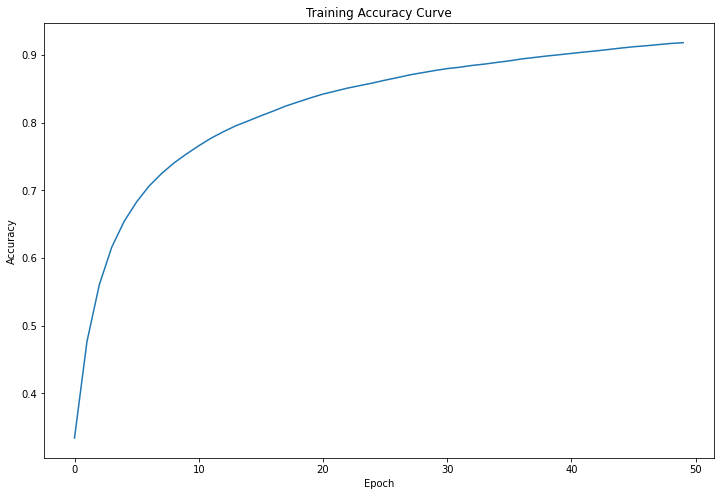

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(range(len(nn.metric_log)),nn.metric_log)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training Accuracy Curve");

In [10]:
test_preds = np.argmax(nn.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('submission.csv', index=False)

## Q3. Tensorflow/Keras to the Rescue
(a) Train your model M with 50 epochs and learning rate = 0.01. Save the predictions of M on the test data in a CSV file and submit it in your KCE.

In [11]:
# import libraries
import tensorflow as tf
import tensorflow_addons as tfa
from time import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
def plot_number(imageToShow, labels):
    plt.imshow(imageToShow,cmap=plt.cm.binary)
    plt.axis(False);
    plt.title(f"{labels}");

In [12]:
import tensorflow as tf
MNIST_model = tf.keras.Sequential([
                                   tf.keras.layers.Flatten(input_shape=(28,28)),
                                   tf.keras.layers.Dense(512, activation='tanh'),
                                   tf.keras.layers.Dense(256, activation='tanh'),
                                   tf.keras.layers.Dense(10, activation='softmax')
                                   ])
MNIST_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy'])
history_MNIST_model = MNIST_model.fit(x, y,
                                      batch_size=32,
                                      epochs=50,
                                      validation_data=(x_validation, y_validation))

2022-10-03 21:55:29.558742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 21:55:29.651906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 21:55:29.652725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 21:55:29.654081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50
1400/1400 [==============================] - 4s 2ms/step - loss: 0.5398 - accuracy: 0.8583 - val_loss: 0.3613 - val_accuracy: 0.9040
Epoch 2/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3195 - accuracy: 0.9075 - val_loss: 0.3164 - val_accuracy: 0.9112
Epoch 3/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2830 - accuracy: 0.9183 - val_loss: 0.2854 - val_accuracy: 0.9208
Epoch 4/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2592 - accuracy: 0.9252 - val_loss: 0.2682 - val_accuracy: 0.9250
Epoch 5/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2394 - accuracy: 0.9305 - val_loss: 0.2505 - val_accuracy: 0.9296
Epoch 6/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2218 - accuracy: 0.9360 - val_loss: 0.2341 - val_accuracy: 0.9329
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2055 - accuracy: 0.9403 - val_loss: 0.2222 - val_accuracy:

### b
Keep other parameters unchanged and experiment with these four optimizers: SGD (with momentum = 0), Adam, Momentum (i.e., SGD with momentum = 0.8), and RMSprop. Fill in Column 1- 4 of Table 1 for each optimizer with 50 epochs of training.

In [13]:
##SGD
SGD_model = tf.keras.models.clone_model(MNIST_model)
SGD_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy'])
start = time()
history_SGD_model = SGD_model.fit(x, y,
                                  batch_size=32,
                                  epochs=50,
                                  validation_data=(x_validation, y_validation))
SGD_training_time = time()-start
SGD_class_acc = accuracy_per_class(y_validation,SGD_model.predict(x_validation))

Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5347 - accuracy: 0.8605 - val_loss: 0.3630 - val_accuracy: 0.8988
Epoch 2/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3188 - accuracy: 0.9082 - val_loss: 0.3142 - val_accuracy: 0.9110
Epoch 3/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2825 - accuracy: 0.9188 - val_loss: 0.2893 - val_accuracy: 0.9177
Epoch 4/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2590 - accuracy: 0.9255 - val_loss: 0.2697 - val_accuracy: 0.9234
Epoch 5/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2394 - accuracy: 0.9310 - val_loss: 0.2522 - val_accuracy: 0.9274
Epoch 6/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2224 - accuracy: 0.9352 - val_loss: 0.2384 - val_accuracy: 0.9324
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2068 - accuracy: 0.9408 - val_loss: 0.2235 - val_accuracy:

In [14]:
##Adam
Adam_model = tf.keras.models.clone_model(SGD_model)
Adam_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=['accuracy'])
start = time()
history_Adam_model = Adam_model.fit(x, y,
                                    batch_size=32,
                                    epochs=50,
                                    validation_data=(x_validation, y_validation))
Adam_training_time = time()-start
Adam_class_acc = accuracy_per_class(y_validation,Adam_model.predict(x_validation))

Epoch 1/50
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5883 - accuracy: 0.8198 - val_loss: 0.5787 - val_accuracy: 0.8290
Epoch 2/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.6010 - accuracy: 0.8258 - val_loss: 0.7563 - val_accuracy: 0.7505
Epoch 3/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.6175 - accuracy: 0.8219 - val_loss: 0.5027 - val_accuracy: 0.8718
Epoch 4/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5934 - accuracy: 0.8348 - val_loss: 0.5550 - val_accuracy: 0.8608
Epoch 5/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5887 - accuracy: 0.8421 - val_loss: 0.5264 - val_accuracy: 0.8579
Epoch 6/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5572 - accuracy: 0.8521 - val_loss: 0.7398 - val_accuracy: 0.7599
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5653 - accuracy: 0.8470 - val_loss: 0.6250 - val_accuracy:

In [15]:
##Momentum
Momentum_model = tf.keras.models.clone_model(Adam_model)
Momentum_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8),
                    metrics=['accuracy'])
start = time()
history_Momentum_model = Momentum_model.fit(x, y,
                                            batch_size=32,
                                            epochs=50,
                                            validation_data=(x_validation, y_validation))
Momentum_training_time = time()-start
Momentum_class_acc = accuracy_per_class(y_validation,Momentum_model.predict(x_validation))

Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3603 - accuracy: 0.8958 - val_loss: 0.2742 - val_accuracy: 0.9204
Epoch 2/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2193 - accuracy: 0.9351 - val_loss: 0.2047 - val_accuracy: 0.9401
Epoch 3/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1654 - accuracy: 0.9508 - val_loss: 0.1651 - val_accuracy: 0.9536
Epoch 4/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1308 - accuracy: 0.9608 - val_loss: 0.1439 - val_accuracy: 0.9589
Epoch 5/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1073 - accuracy: 0.9681 - val_loss: 0.1252 - val_accuracy: 0.9659
Epoch 6/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 0.1119 - val_accuracy: 0.9682
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0758 - accuracy: 0.9780 - val_loss: 0.1071 - val_accuracy:

In [16]:
##RMSprop
RMSprop_model = tf.keras.models.clone_model(Momentum_model)
RMSprop_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
                    metrics=['accuracy'])
start = time()
history_RMSprop_model = RMSprop_model.fit(x, y,
                                          batch_size=32,
                                          epochs=50,
                                          validation_data=(x_validation, y_validation))
RMSprop_training_time = time()-start
RMSprop_class_acc = accuracy_per_class(y_validation,RMSprop_model.predict(x_validation))

Epoch 1/50
1400/1400 [==============================] - 4s 2ms/step - loss: 0.5670 - accuracy: 0.8533 - val_loss: 0.3380 - val_accuracy: 0.9163
Epoch 2/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3478 - accuracy: 0.9155 - val_loss: 0.3368 - val_accuracy: 0.9177
Epoch 3/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3241 - accuracy: 0.9247 - val_loss: 0.4506 - val_accuracy: 0.8963
Epoch 4/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3152 - accuracy: 0.9292 - val_loss: 0.3091 - val_accuracy: 0.9302
Epoch 5/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2998 - accuracy: 0.9330 - val_loss: 0.2983 - val_accuracy: 0.9383
Epoch 6/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2954 - accuracy: 0.9335 - val_loss: 0.3345 - val_accuracy: 0.9318
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2821 - accuracy: 0.9390 - val_loss: 0.3197 - val_accuracy:

In [17]:
# Accuracy per class
merge_on = 'Class'
label_acc = pd.DataFrame(SGD_class_acc).merge(pd.DataFrame(Adam_class_acc), on=merge_on).merge(pd.DataFrame(Momentum_class_acc), on=merge_on).merge(pd.DataFrame(RMSprop_class_acc), on=merge_on)
label_acc.columns = [merge_on,'SGD', 'Adam', 'Momentum', 'RMSprop']
label_acc

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Accuracy_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,Class,SGD,Adam,Momentum,RMSprop
0,0,0.996875,0.987232,0.997054,0.993571
1,1,0.996786,0.977857,0.997679,0.993036
2,2,0.995625,0.980000,0.996250,0.989911
3,3,0.992679,0.960714,0.993393,0.988839
4,4,0.995089,0.971429,0.996161,0.991875
5,5,0.994821,0.973036,0.995446,0.991250
6,6,0.996339,0.976429,0.997411,0.994643
7,7,0.994732,0.970625,0.996161,0.983214
8,8,0.994911,0.969018,0.995536,0.982857
9,9,0.992143,0.972054,0.993661,0.979554


In [18]:
# training time
pd.Series({'SGD': SGD_training_time,'ADAM':Adam_training_time,'Momentum': Momentum_training_time,'RMSprop':RMSprop_training_time})

SGD         138.596586
ADAM        148.062835
Momentum    142.482096
RMSprop     202.595376
dtype: float64

In [19]:
# SGD
test_preds = np.argmax(SGD_model.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('SGDsubmission.csv', index=False)
# ADAM
test_preds = np.argmax(Adam_model.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('Adamsubmission.csv', index=False)
# Momentum
test_preds = np.argmax(Momentum_model.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('Momentumsubmission.csv', index=False)
#RMSprop
test_preds = np.argmax(RMSprop_model.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('RMSpropsubmission.csv', index=False)

### c - Data Augmentation

Your test dataset contains some flipped/rotated images as illustrated in Figure 2. In order to classify them properly, you need to implement the following two image augmentation methods and include the new images in your training data.

i. Flipping: For each image in your training data, flip the image horizontally and vertically. Add the two new images to your training data with the same label.

ii. Rotation: For each image in your training data, rotate the image clockwise 45 degrees 7 times. Add the seven new images to your training data with the same label.

Initialize and train your model M again as specified in 3(a), but now including the augmented input data (it should be 9 times more than the original one). Save the predictions of the new model on the test data in a CSV file and submit it in your KCE. Fill in Column 5 of Table 1 with your training and test statistics.

In [66]:
# Test augmentation
entry_augmented = 5
horizontally_flipped = np.squeeze(tf.image.random_flip_left_right(x.reshape(-1, 28, 28, 1)))[entry_augmented]
vertically_flipped = np.squeeze(tf.image.random_flip_up_down(x.reshape(-1, 28, 28, 1)))[entry_augmented]

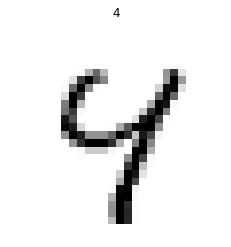

In [61]:
plot_number(x[entry_augmented], y[entry_augmented])

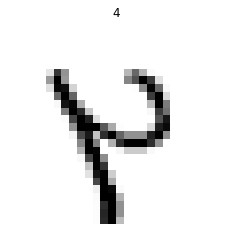

In [67]:
plot_number(horizontally_flipped, y[entry_augmented])

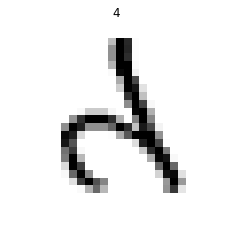

In [63]:
plot_number(vertically_flipped, y[entry_augmented])

In [20]:
# Generate new dataset with augmented data
def augment_data(x, y):
  x = x.reshape(-1, 28, 28, 1)
  images = np.squeeze(x) # original
  images = np.concatenate((images, np.squeeze(tf.image.random_flip_left_right(x))), axis=0) # horizontal flip
  images = np.concatenate((images, np.squeeze(tf.image.random_flip_up_down(x))), axis=0) # vertical flip
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 45))), axis=0) # rotate 45 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 90))), axis=0) # rotate 90 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 135))), axis=0) # rotate 135 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 180))), axis=0) # rotate 180 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 225))), axis=0) # rotate 225 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 270))), axis=0) # rotate 270 degrees
  images = np.concatenate((images, np.squeeze(tfa.image.rotate(x, 315))), axis=0) # rotate 315 degrees   
  y = np.concatenate((y,y,y,y,y,y,y,y,y,y),axis=0)
  return images, y
x_augmented, y_augmented = augment_data(x, y)

In [21]:
# 10x images
y_augmented.shape

(448000,)

In [22]:
# train model with augmented dataset
import tensorflow as tf
augmented_model = tf.keras.Sequential([
                                   tf.keras.layers.Flatten(input_shape=(28,28)),
                                   tf.keras.layers.Dense(512, activation='tanh'),
                                   tf.keras.layers.Dense(256, activation='tanh'),
                                   tf.keras.layers.Dense(10, activation='softmax')
                                   ])
augmented_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy'])
start = time()
history_augmented_model = augmented_model.fit(tf.constant(x_augmented), tf.constant(y_augmented),
                                      batch_size=32,
                                      epochs=50,
                                      validation_data=(tf.constant(x_validation), tf.constant(y_validation)))
augmented_model_training_time = time()-start
augmented_model_class_acc = accuracy_per_class(y_validation,augmented_model.predict(x_validation))

2022-10-03 22:11:05.703377: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2809856000 exceeds 10% of free system memory.
2022-10-03 22:11:08.913794: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2809856000 exceeds 10% of free system memory.


Epoch 1/50
14000/14000 [==============================] - 25s 2ms/step - loss: 0.8497 - accuracy: 0.7354 - val_loss: 0.3704 - val_accuracy: 0.8956
Epoch 2/50
14000/14000 [==============================] - 24s 2ms/step - loss: 0.3953 - accuracy: 0.8840 - val_loss: 0.2389 - val_accuracy: 0.9330
Epoch 3/50
14000/14000 [==============================] - 24s 2ms/step - loss: 0.2787 - accuracy: 0.9171 - val_loss: 0.1768 - val_accuracy: 0.9481
Epoch 4/50
14000/14000 [==============================] - 24s 2ms/step - loss: 0.2232 - accuracy: 0.9335 - val_loss: 0.1481 - val_accuracy: 0.9558
Epoch 5/50
14000/14000 [==============================] - 24s 2ms/step - loss: 0.1886 - accuracy: 0.9432 - val_loss: 0.1375 - val_accuracy: 0.9580
Epoch 6/50
14000/14000 [==============================] - 24s 2ms/step - loss: 0.1644 - accuracy: 0.9507 - val_loss: 0.1239 - val_accuracy: 0.9619
Epoch 7/50
14000/14000 [==============================] - 23s 2ms/step - loss: 0.1461 - accuracy: 0.9560 - val_loss: 0

In [23]:
# Accuracy per Class
augmented_model_class_acc = accuracy_per_class(y_validation,augmented_model.predict(x_validation))
augmented_model_class_acc

{'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'Accuracy': [0.9969642857142857,
  0.9975892857142857,
  0.9925,
  0.9922321428571429,
  0.995625,
  0.9901785714285715,
  0.9957142857142857,
  0.9938392857142857,
  0.9940178571428572,
  0.9924107142857143]}

In [24]:
# Training time
augmented_model_training_time

1227.6001434326172

In [25]:
test_preds = np.argmax(augmented_model.predict(x_test), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_preds)+1), 'class':test_preds})
FernandoSubmission.to_csv('augmented_submission.csv', index=False)

*Disclaimer*: Results may differ from the Table 1 Performance Statistics in the PDF since I've run this notebook multiple times.